In [1]:
import pandas as pd
import random
from sklearn import preprocessing
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
def pitch_csv_to_dic(df):
    # dictionary with player id keys and values tuples of pitch type and percent pitched
    player_pitch = {}
    # set of all the types of pitches 
    pitch_types = set()
    for indx, row in df.iterrows():
        player_id = row["player_id"]
        pitch_type = row["pitch_type"]
        pitch_usage = row["pitch_usage"]
        pitch_types.add(pitch_type)

        if row["player_id"] in player_pitch:
            player_pitch[row["player_id"]].append((pitch_type,pitch_usage))
        else:
            player_pitch[row["player_id"]] = [(pitch_type,pitch_usage)]
        
    return player_pitch, pitch_types

def custom_encode(y):
    new_y = []
    for i, elem in enumerate(y):
        vec = [0,0,0,0,0,0]
        if elem == "CH":
            vec[0] = 1
        elif elem == "FF":
            vec[1] = 1
        elif elem == "KC":
            vec[2] = 1
        elif elem == "SL":
            vec[3] = 1
        elif elem == "SI":
            vec[4] = 1
        elif elem == "CU":
            vec[5] = 1
        else:
            print("error invalid y")
        new_y.append(vec)
    return new_y

In [3]:
plays = pd.read_csv('full_cole_data.csv')

print(plays.columns)

pitch_types = {}
drop_indexes = []

for index, row in plays.iterrows():
    # keep track of number of pitches in each category
    pitch_type = row["pitch_type"]
        
    if pitch_type in pitch_types:
        pitch_types[pitch_type] += 1
    else:
        pitch_types[pitch_type] = 1
    
    # SI(sinker) and FT(2 seam fastball) synonymous w each other, so combine to one category
    if pitch_type == "FT":
        plays.at[index, "pitch_type"] = "SI"
    # remove PO(pitch out)(6 values), IN(intentional ball)(18 values), remove nan pitch types(30 values) (data messed up)
    # remove FA(fastball)(1 value) bc not a specific type of fastball
    if pitch_type == "PO" or pitch_type == "IN" or pitch_type == "P0" or pd.isna(pitch_type) or pitch_type == "FA":
        drop_indexes.append(index)

clean_plays = plays
# remove PO(pitch out)(6 values), IN(intentional ball)(18 values), remove nan pitch types(30 values) (data messed up)
for index in drop_indexes:
    clean_plays = clean_plays.drop(index)

C:\Users\91133\Anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (43) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [4]:
print(len(plays.columns))
print(pitch_types)
print(plays.shape)
print(clean_plays.shape)

92
{'CH': 1791, 'FF': 12186, 'KC': 3291, 'SL': 4893, 'SI': 1344, 'FT': 904, nan: 30, 'PO': 6, 'IN': 18, 'CU': 49, 'FA': 1}
(24513, 92)
(24458, 92)


In [5]:
pitch_types2 = {}
total_pitches = len(clean_plays)
for index, row in clean_plays.iterrows(): 
    pitch_type = row["pitch_type"]
    if pitch_type in pitch_types2:
        pitch_types2[pitch_type] += 1
    else:
        pitch_types2[pitch_type] = 1

In [6]:
print(pitch_types2)
print(total_pitches)
pitch_frequency = []
for key in pitch_types2.keys():
    pitch_frequency.append(pitch_types2[key] / total_pitches)
print(pitch_frequency)

{'CH': 1791, 'FF': 12186, 'KC': 3291, 'SL': 4893, 'SI': 2248, 'CU': 49}
24458
[0.07322757379998364, 0.49824188404611985, 0.1345572000981274, 0.20005724098454494, 0.09191266661215144, 0.002003434459072696]


In [7]:
x = []
y_og = []
# gather data to feed into network
for indx, row in clean_plays.iterrows():
    pitch = row["pitch_type"]
    balls = row["balls"]
    strikes = row["strikes"]
    inning = row["inning"]
    outs = row["outs_when_up"]
    score_diff = row["fld_score"] - row["bat_score"]
    if row["stand"] == "R":
        batter_stance = 1
    else:
         batter_stance = 0
    
    y_og.append(pitch)
    x.append([balls,strikes,outs,inning, score_diff, batter_stance])

# one hot encode pitch names
y = custom_encode(y_og)

In [8]:
# shuffle up data
combined = list(zip(x, y))
random.shuffle(combined)
x[:], y[:] = zip(*combined)

# seperate data into train and test sets
x_train = x[:int(len(x)*0.9)]
y_train = y[:int(len(x)*0.9)]
x_test = x[int(len(x)*0.9):]
y_test = y[int(len(x)*0.9):]

In [9]:
model = Sequential()
model.add(Dense(10,input_dim=6, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=1)

Epoch 1/20
172/172 [==============================] - 2s 4ms/step - loss: 1.5089 - accuracy: 0.4707
Epoch 2/20
172/172 [==============================] - 0s 3ms/step - loss: 1.3762 - accuracy: 0.4987
Epoch 3/20
172/172 [==============================] - 0s 3ms/step - loss: 1.3537 - accuracy: 0.4987
Epoch 4/20
172/172 [==============================] - 0s 3ms/step - loss: 1.3426 - accuracy: 0.4987
Epoch 5/20
172/172 [==============================] - 0s 3ms/step - loss: 1.3349 - accuracy: 0.4988
Epoch 6/20
172/172 [==============================] - 0s 3ms/step - loss: 1.3293 - accuracy: 0.4983
Epoch 7/20
172/172 [==============================] - 0s 3ms/step - loss: 1.3252 - accuracy: 0.4986
Epoch 8/20
172/172 [==============================] - 0s 3ms/step - loss: 1.3223 - accuracy: 0.4983
Epoch 9/20
172/172 [==============================] - 0s 3ms/step - loss: 1.3196 - accuracy: 0.4985
Epoch 10/20
172/172 [==============================] - 0s 3ms/step - loss: 1.3173 - accuracy: 0.4984

In [10]:
score = model.evaluate(x_test, y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 1.3249610662460327
Test accuracy: 0.49386754631996155


In [11]:
pred = model.predict(x_test) 

In [12]:
print(pitch_types2)
CH = []
FF = []
KC = []
SL = []
SI = []
CU = []
for p in pred:
    CH.append(p[0])
    FF.append(p[1])
    KC.append(p[2])
    SL.append(p[3])
    SI.append(p[4])
    CU.append(p[5])

{'CH': 1791, 'FF': 12186, 'KC': 3291, 'SL': 4893, 'SI': 2248, 'CU': 49}


In [13]:
import matplotlib.pyplot as plt

Change Up samples:  1791


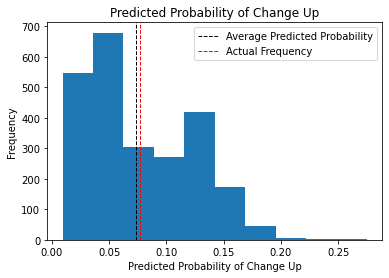

In [14]:
plt.hist(CH)
plt.xlabel("Predicted Probability of Change Up")
plt.ylabel("Frequency")
plt.title("Predicted Probability of Change Up")
plt.axvline(pitch_frequency[0], color='k', linestyle='dashed', linewidth=1, label="Average Predicted Probability")
plt.axvline(sum(CH)/len(CH), color='r', linestyle='dashed', linewidth=1, label="Actual Frequency")
plt.legend(loc="upper right")
print("Change Up samples: ", pitch_types2["CH"])

Four-Seam Fastball samples:  12186


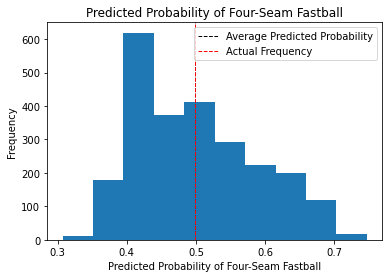

In [15]:
plt.hist(FF)
plt.xlabel("Predicted Probability of Four-Seam Fastball")
plt.ylabel("Frequency")
plt.title("Predicted Probability of Four-Seam Fastball")
plt.axvline(pitch_frequency[1], color='k', linestyle='dashed', linewidth=1, label="Average Predicted Probability")
plt.axvline(sum(FF)/len(FF), color='r', linestyle='dashed', linewidth=1, label="Actual Frequency")
plt.legend(loc="upper right")
print("Four-Seam Fastball samples: ", pitch_types2["FF"])

Knuckle Curve samples:  3291


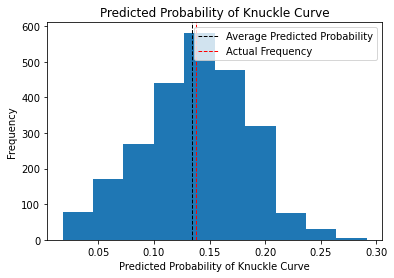

In [16]:
plt.hist(KC)
plt.xlabel("Predicted Probability of Knuckle Curve")
plt.ylabel("Frequency")
plt.title("Predicted Probability of Knuckle Curve")
plt.axvline(pitch_frequency[2], color='k', linestyle='dashed', linewidth=1, label="Average Predicted Probability")
plt.axvline(sum(KC)/len(KC), color='r', linestyle='dashed', linewidth=1, label="Actual Frequency")
plt.legend(loc="upper right")
print("Knuckle Curve samples: ", pitch_types2["KC"])

Slider samples:  4893


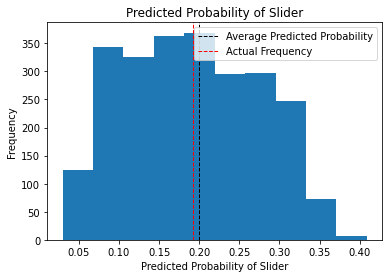

In [17]:
plt.hist(SL)
plt.xlabel("Predicted Probability of Slider")
plt.ylabel("Frequency")
plt.title("Predicted Probability of Slider")
plt.axvline(pitch_frequency[3], color='k', linestyle='dashed', linewidth=1, label="Average Predicted Probability")
plt.axvline(sum(SL)/len(SL), color='r', linestyle='dashed', linewidth=1, label="Actual Frequency")
plt.legend(loc="upper right")
print("Slider samples: ", pitch_types2["SL"])

Sinker samples:  2248


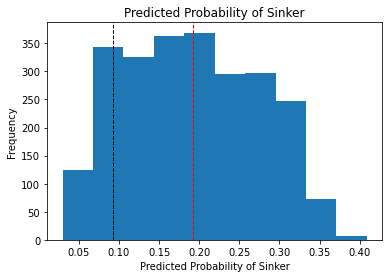

In [18]:
plt.hist(SL)
plt.xlabel("Predicted Probability of Sinker")
plt.ylabel("Frequency")
plt.title("Predicted Probability of Sinker")
plt.axvline(pitch_frequency[4], color='k', linestyle='dashed', linewidth=1, label="Average Predicted Probability")
plt.axvline(sum(SL)/len(SL), color='r', linestyle='dashed', linewidth=1, label="Actual Frequency")
print("Sinker samples: ", pitch_types2["SI"])

Cuter samples:  49


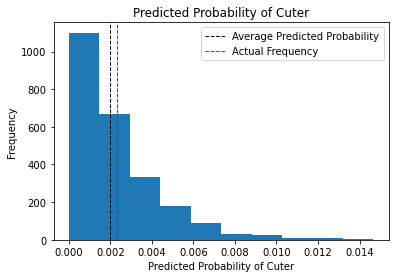

In [19]:
plt.hist(CU)
plt.xlabel("Predicted Probability of Cuter")
plt.ylabel("Frequency")
plt.title("Predicted Probability of Cuter")
plt.axvline(pitch_frequency[5], color='k', linestyle='dashed', linewidth=1, label="Average Predicted Probability")
plt.axvline(sum(CU)/len(CU), color='r', linestyle='dashed', linewidth=1, label="Actual Frequency")
plt.legend(loc="upper right")
print("Cuter samples: ", pitch_types2["CU"])

[0, 1, 0, 0, 0, 0]


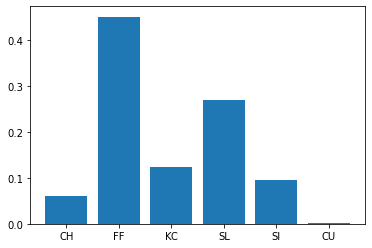

In [21]:
plt.bar(["CH","FF","KC","SL","SI","CU"],pred[1111])
print(y_test[1111])